In [2]:
cd /media/sf_datasets/Smarter\ Devices/BLUED_extracted/BLUED-TK

/media/sf_datasets/Smarter Devices/BLUED_extracted/BLUED-TK


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split as tts
import sklearn as sk
from sklearn.metrics import  classification_report 
import pylab as pl
from imblearn.over_sampling import RandomOverSampler

In [28]:
#reading the dataframe
df=pd.read_table('events/peaks_updated.txt',index_col=0,sep=',')


cols=[str(i) for i in range(70)]
cols+=['labels','phase']

df.columns=cols
#finding the single event devices
freq=df.groupby('labels').count()
single_freq=freq[freq['0']==1].index

# printing the values by count
# df.groupby('label').count().sort_values(by='features')

#eliminating all the single event devices
for i in single_freq:
    df=(df[df['labels']!=i])

df=df[df['phase']=='A']
for i in range(0,10):
    del df[str(i)]

del df['phase']

print("Events left after removal of single events %d"%len(df))

device_list=df['labels'].unique()
print('output devices %s'%len(device_list))

Events left after removal of single events 897
output devices 9


In [29]:
#convert the dataframe to matrix
temp=df.copy()
del temp['labels']
feature_matrix=temp.as_matrix()
labels=np.array(df['labels'])
inputs=feature_matrix.shape[1]
outputs=len(device_list)
total_events=len(df)

In [30]:
#matrices shape
feature_matrix=(feature_matrix-feature_matrix.mean(axis=0))/feature_matrix.var(axis=0)
label_matrix=labels
print (feature_matrix.shape, label_matrix.shape)

#Oversampler
# ros = RandomOverSampler(random_state = 42)
# feature_matrix, label_matrix= ros.fit_sample(feature_matrix, label_matrix)
feature_train, feature_test, label_train, label_test = tts(feature_matrix, label_matrix, test_size=0.3, random_state=42,stratify=label_matrix)


(897, 60) (897,)


In [31]:

def to_onehot(vect):
    vect_raw,indicies=np.unique(vect,return_inverse=True)
    one_hot_vect=np.zeros((vect.shape[0],vect_raw.shape[0])).astype('int64')
    one_hot_vect[np.arange(vect.shape[0]),indicies]=1
    return one_hot_vect

#convert the oversampled lables to one_hot
label_train=to_onehot(label_train)
label_test=to_onehot(label_test)

print('Total events is %s'%(total_events))

Total events is 897


In [32]:
print('feature_train.shape=%s label_train.shape=%s'%(feature_train.shape,label_train.shape)) 
print('feature_test.shape=%s label_test.shape=%s'%(feature_test.shape,label_test.shape)) 
print('inputs=%d output=%d'%(inputs,outputs))
feature_train

feature_train.shape=(627, 60) label_train.shape=(627, 9)
feature_test.shape=(270, 60) label_test.shape=(270, 9)
inputs=60 output=9


array([[  2.54276471e+00,   1.73168255e-01,   8.59905437e-02, ...,
          9.52735143e-02,   9.18210790e-02,   9.59028083e-02],
       [ -2.86188097e-02,  -3.03868549e-02,   8.43028338e-04, ...,
          8.70258857e-02,   8.50286324e-02,   8.61534342e-02],
       [  1.68810910e+00,   1.72973396e-01,   8.48886707e-02, ...,
          9.26916015e-02,   9.06770319e-02,   9.61916086e-02],
       ..., 
       [ -2.62517818e-02,  -4.18950569e-02,  -3.93115608e-02, ...,
         -6.68091903e-02,  -7.11962237e-02,  -6.87523432e-02],
       [ -6.53866428e-02,   3.01012150e-02,  -8.85481565e-03, ...,
          5.59719583e-02,   5.12096665e-02,   5.63277112e-02],
       [ -4.09273547e-02,  -4.27840494e-02,  -3.98271778e-02, ...,
         -7.34789570e-02,  -7.35556818e-02,  -7.11355070e-02]])

In [33]:
layer1=200
layer2=100


x = tf.placeholder(tf.float32, shape=[None, inputs])
y = tf.placeholder(tf.float32, shape=[None, outputs])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([inputs, layer1])),
    'h2' :tf.Variable(tf.random_normal([layer1, layer2])),
    'ho' :tf.Variable(tf.random_normal([layer2, outputs])),    
}
biases = {
    'b1': tf.Variable(tf.random_normal([layer1])),
    'b2': tf.Variable(tf.random_normal([layer2])),
    'out': tf.Variable(tf.random_normal([outputs]))
}



In [34]:
#output layer
def ann(x,weights,biases):
    layer1=tf.add(tf.matmul(x,weights['h1']),biases['b1'])
    ac1=tf.nn.sigmoid(layer1)#,0.2)
    layer2=tf.add(tf.matmul(ac1, weights['h2']), biases['b2'])
    ac2=tf.nn.sigmoid(layer2)#,0.2)
    out_layer = tf.add(tf.matmul(ac2, weights['ho']), biases['out'])
    return out_layer

pred = ann(x, weights, biases)

In [35]:
def onehot_to_labels(arr,device_list,ismat=True):
    new_label=[]
    if ismat==True:
        x,y=np.where(arr==1)
        del x
        for i in y:
            new_label.append(device_list[i])
    else:
        for i in arr:
            new_label.append(device_list[i])
    return new_label

In [36]:
# Parameters
#learning_rate = 0.09
training_epochs = 10000
display_step = training_epochs/10
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.7
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost, global_step = global_step)


correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  

# Launch the graph
sess = tf.InteractiveSession()

y_pred=False
with  tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        _, c = sess.run([optimizer, cost], feed_dict={x: feature_train,y: label_train})
        if not epoch%display_step:
            print ("Cost : "+str(c)+" : Accuracy:%f" %(accuracy.eval({x: feature_test, y: label_test})*100))
    y_p = tf.argmax(pred, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:feature_test, y:label_test})
    
y_pred=onehot_to_labels(y_pred,device_list,ismat=False)
y_true=onehot_to_labels(label_test,device_list)
report=classification_report(y_pred=y_pred,y_true=y_true, digits = 3)

Cost : 16.1767 : Accuracy:73.333335
Cost : 0.488554 : Accuracy:81.111103
Cost : 0.416829 : Accuracy:82.222223
Cost : 0.377411 : Accuracy:81.851846
Cost : 0.330654 : Accuracy:84.074080
Cost : 0.295468 : Accuracy:85.925925
Cost : 0.261142 : Accuracy:84.074068
Cost : 0.241216 : Accuracy:85.185182
Cost : 0.216931 : Accuracy:85.555553
Cost : 0.1951 : Accuracy:85.555553


/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
print(report)

             precision    recall  f1-score   support

        108      1.000     0.857     0.923         7
        111      0.920     0.985     0.951       198
        127      0.500     0.286     0.364         7
        132      0.800     0.645     0.714        31
        147      0.000     0.000     0.000         2
        148      0.333     0.385     0.357        13
        156      0.167     0.200     0.182         5
        158      1.000     0.500     0.667         2
        207      1.000     0.200     0.333         5

avg / total      0.850     0.856     0.845       270



[[  6   1   0   0   0   0   0   0   0]
 [  0 195   0   3   0   0   0   0   0]
 [  0   0   2   0   0   5   0   0   0]
 [  0   9   0  20   0   1   1   0   0]
 [  0   2   0   0   0   0   0   0   0]
 [  0   1   2   1   0   5   4   0   0]
 [  0   3   0   1   0   0   1   0   0]
 [  0   0   0   0   0   1   0   1   0]
 [  0   1   0   0   0   3   0   0   1]]


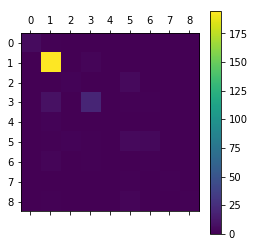

In [38]:
cm=sk.metrics.confusion_matrix(y_true, y_pred)
print(cm)
pl.matshow(cm)
pl.colorbar()
pl.show()

In [39]:
'''Device wise manually calculated'''
# # Parameters
# #learning_rate = 0.09
# training_epochs = 5000
# display_step = training_epochs/10
# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.7
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            100000, 0.96, staircase=True)
# # Define loss and optimizer
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
# optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost, global_step = global_step)


# # Launch the graph
# sess = tf.InteractiveSession()

# with tf.Session() as sess:
#     # Initializing the variables
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     # Training cycle
#     for epoch in range(training_epochs):
#         avg_cost = 0.
#         _, c = sess.run([optimizer, cost], feed_dict={x: feature_train,
#                                                       y: label_train})
#         avg_cost = c 
#         correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#         # Calculate accuracy
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#         if not epoch%display_step:
#             print ("Cost : "+str(c)+" : Accuracy:%f" %(accuracy.eval({x: feature_test, y: label_test})*100))

#     #  Device-wise efficiency
#     c=0
#     for label in device_list:
#         #take the relevant feature data      
#         cond=label_test[:,c]==1
#         dev_features=feature_test[cond]
#         dev_label=label_test[cond]
#         c+=1
#         print('Accuracy for %s is %5.3f (%02d events)'%(label,(accuracy.eval({x: dev_features, y: dev_label})*100),len(dev_label)))

'Device wise manually calculated'